#  Using real world data

Welcome! you will be using the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs you will also use Convolutional layers to improve the model's performance.

Let's get started!

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

Begin by looking at the structure of the csv that contains the data:

In [2]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data
Now you need to read the data from the csv file. To do so, complete the `parse_data_from_file` function.

A couple of things to note:

- You should omit the first line as the file contains headers.
- There is no need to save the data points as numpy arrays, regular lists is fine.
- To read from csv files use `csv.reader` by passing the appropriate arguments.
- `csv.reader` returns an iterable that returns each row in every iteration. So the temperature can be accessed via row[1] and the date can be discarded.
- The `times` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `temperatures` list.
- The values of the `temperatures` should be of `float` type. You can use Python's built-in `float` function to ensure this.

In [8]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []
    with open(filename) as csvfile:
        
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        i = 0
        for row in reader:
            times.append(i)
            temperatures.append(float(row[1]))
            i+=1
            
    return times, temperatures

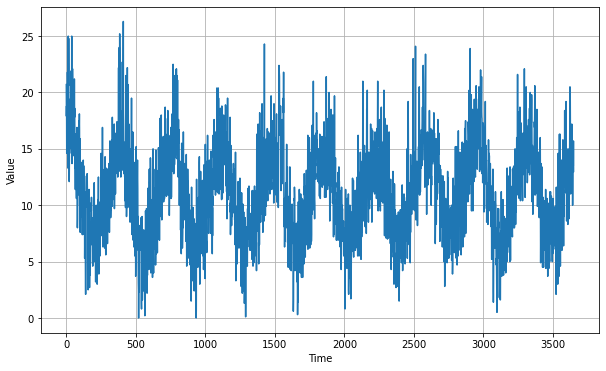

In [9]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data



In [10]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [11]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define your layer architecture. Just as in last week's assignment you will do the layer definition and compilation in two separate steps. Begin by completing the `create_uncompiled_model` function below.

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

Hint:

- `Lambda` layers are not required.
- Use a combination of `Conv1D` and `LSTM` layers followed by `Dense` layers

In [18]:
def create_uncompiled_model():

    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv1D(filters = 60, kernel_size = 5, strides = 1, padding = 'causal', activation = 'relu', input_shape = [None, 1]),
        tf.keras.layers.LSTM(60, return_sequences = True),
        tf.keras.layers.LSTM(60),
        tf.keras.layers.Dense(30, activation = 'relu'),
        tf.keras.layers.Dense(15, activation = 'relu'),
        tf.keras.layers.Dense(1)
        
    ]) 
    

    return model

You can test your model with the code below. If you get an error, it's likely that your model is returning a sequence. You can indeed use an LSTM with `return_sequences=True` but you have to feed it into another layer that generates a single prediction. You can review the lectures or the previous ungraded labs to see how that is done.

In [19]:
# Test your uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):
    
    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)
    
# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate -

As you saw in the lectures, you can leverage Tensorflow's callbacks to dynamically vary the learning rate before doing the actual training. This can be helpful in finding what value works best with your model. Note that this is only one way of finding the best learning rate. There are other techniques for hyperparameter optimization but it is outside the scope of this course.

For the optimizers you can try out:

- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [20]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum = 0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss='mse',
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [21]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 11s 106ms/step - loss: 65.0009 - mae: 6.4891 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 8s 101ms/step - loss: 11.4504 - mae: 2.6419 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 8s 103ms/step - loss: 7.4040 - mae: 2.1280 - lr: 7.9433e-04
Epoch 20/100
77/77 [==============================] - 8s 105ms/step - loss: 7.7065 - mae: 2.1801 - lr: 8.9125e-04
Epoch 21/100
77/77 [==============================] - 8s 108ms/step - loss: 7.4899 - mae: 2.1502 - lr: 0.0010
Epoch 22/100
77/77 [==============================] - 8s 106ms/step - loss: 7.6971 - mae: 2.1769 - lr: 0.0011
Epoch 23/100
77/77 [==============================] - 8s 108ms/step - loss: 7.2385 - mae: 2.1015 - lr: 0.0013
Epoch 24/100
77/77 [==============================] - 8s 105ms/step - loss: 6.6503 - mae: 2.0203 - lr: 0.0014
Epoch 25/100
77/77 [==============================] - 8s 106ms/step - loss: 8.6309 - mae: 2.2907 - lr: 0

(0.0001, 10.0, 0.0, 10.0)

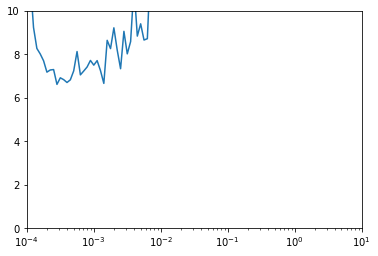

In [22]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

## Compiling the model
Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hints:

- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: loss: nan - mae: nan it is very likely that your network is suffering from exploding gradients. This is a common problem if you used SGD as optimizer and set a learning rate that is too high. If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.

In [25]:
def create_model():

    
    model = create_uncompiled_model()


    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.SGD(learning_rate = 1e-3, momentum = 0.9),
                  metrics=["mae"])  
    


    return model

In [26]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 11s 103ms/step - loss: 31.5873 - mae: 4.2216
Epoch 2/50
77/77 [==============================] - 8s 103ms/step - loss: 12.4513 - mae: 2.7333
Epoch 3/50
77/77 [==============================] - 8s 100ms/step - loss: 8.3883 - mae: 2.2821
Epoch 4/50
77/77 [==============================] - 8s 101ms/step - loss: 7.6813 - mae: 2.1808
Epoch 5/50
77/77 [==============================] - 8s 101ms/step - loss: 8.0916 - mae: 2.2472
Epoch 6/50
77/77 [==============================] - 8s 103ms/step - loss: 7.4245 - mae: 2.1406
Epoch 7/50
77/77 [==============================] - 8s 100ms/step - loss: 7.1569 - mae: 2.0951
Epoch 8/50
77/77 [==============================] - 8s 102ms/step - loss: 6.5902 - mae: 2.0109
Epoch 9/50
77/77 [==============================] - 8s 99ms/step - loss: 6.6979 - mae: 2.0385
Epoch 10/50
77/77 [==============================] - 8s 101ms/step - loss: 7.0524 - mae: 2.0946
Epoch 11/50
77/77 [============================

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [27]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.



## Faster model forecasts

In the previous week you saw a faster approach compared to using a for loop to compute the forecasts for every point in the sequence. Remember that this faster approach uses batches of data. 

The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [28]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Now compute the actual forecast:

**Note:** Don't modify the cell below. 

The grader uses the same slicing to get the forecast so if you change the cell below you risk having issues when submitting your model for grading.

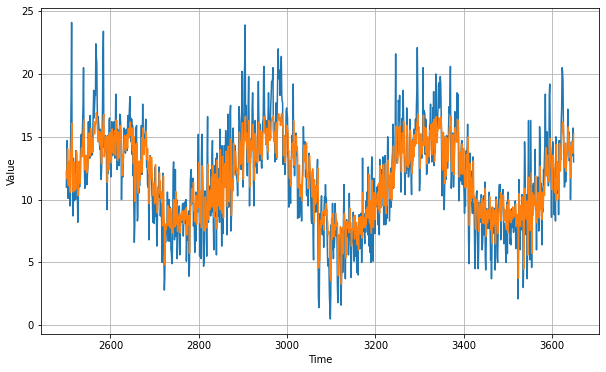

In [29]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [30]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.34, mae: 1.81 for forecast


In [ ]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets
